In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from ultralytics import YOLO

In [13]:
class SiameseYOLO(nn.Module):
    def __init__(self, yolo_weights='yolov8m.pt'):
        super(SiameseYOLO, self).__init__()
        self.yolo = YOLO(yolo_weights)
        self.backbone = self.yolo.model.model[:10]  # Use YOLOv8m backbone (up to C3 layer)

    def forward(self, support_img, query_img):
        support_feat = self.backbone(support_img)[-1]  # [B, C, H, W]
        query_feat = self.backbone(query_img)[-1]

        # Normalize
        support_feat = F.normalize(support_feat, p=2, dim=1)
        query_feat = F.normalize(query_feat, p=2, dim=1)

        # Cosine similarity
        similarity = (query_feat * support_feat).sum(dim=1, keepdim=True)
        return similarity

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640), antialias=True)
])

In [17]:
def load_image(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return transform(img_rgb).unsqueeze(0), img

In [ ]:
#Training the model
model = SiameseYOLO()
model.eval()

In [ ]:
model = SiameseYOLO(yolo_weights='/path/to/runs/detect/train/weights/best.pt')

In [ ]:
support_tensor, _ = load_image("/path/to/support.jpg")
query_tensor, query_img = load_image("/path/to/query_image.jpg")

In [23]:
with torch.no_grad():
    similarity = model(support_tensor, query_tensor)  # [1, 1, H, W]
    sim_map = similarity.squeeze().cpu().numpy()
    sim_map_bin = (sim_map > 0.9).astype(np.uint8) * 255

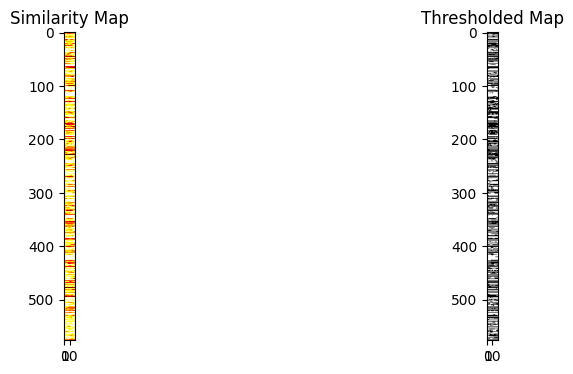

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Similarity Map")
plt.imshow(sim_map, cmap='hot')
plt.subplot(1, 2, 2)
plt.title("Thresholded Map")
plt.imshow(sim_map_bin, cmap='gray')
plt.show()

In [25]:
contours, _ = cv2.findContours(sim_map_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    scale_x = query_img.shape[1] / 640
    scale_y = query_img.shape[0] / 640
    cv2.rectangle(query_img, (int(x * scale_x), int(y * scale_y)),
                  (int((x + w) * scale_x), int((y + h) * scale_y)), (0, 255, 0), 2)

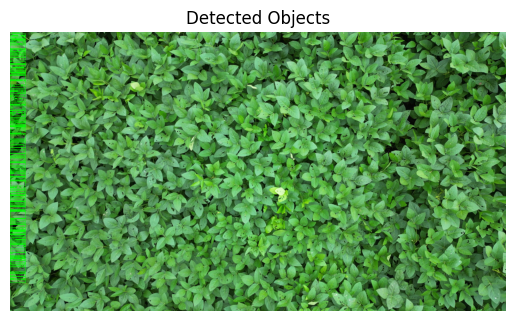

In [26]:
cv2.imwrite("detected.jpg", query_img)
plt.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects")
plt.axis("off")
plt.show()

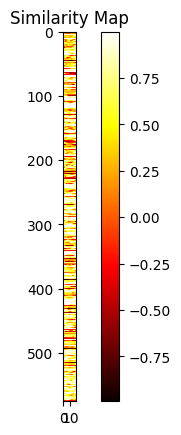

In [27]:
plt.imshow(sim_map, cmap='hot')
plt.title("Similarity Map")
plt.colorbar()
plt.show()


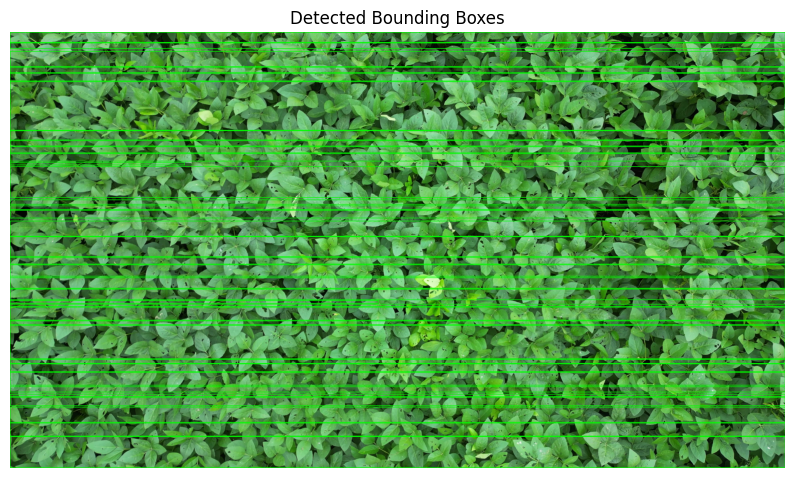

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the query image (the one you want to draw boxes on)
image = cv2.imread("Soyabean_UAV-Based_Image_Dataset/Soyabean Semilooper and Caterpillar_Pest_Attack/Soyabean Semilooper_Pest_Attack/DJI_0066_000001.jpg")

# Assume sim_map_bin already exists from your SiameseYOLO inference:
# sim_map_bin = (sim_map > 0.9).astype(np.uint8) * 255

# Resize the binary similarity map to match the query image size
sim_map_bin_resized = cv2.resize(sim_map_bin, (image.shape[1], image.shape[0]))

# Find contours in the resized binary similarity map
contours, _ = cv2.findContours(sim_map_bin_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on the image
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:  # Optional: filter small boxes
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Save and display the final result
cv2.imwrite("final_detected_with_boxes.jpg", image)

# Show the result using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Bounding Boxes")
plt.axis("off")
plt.show()
